# レンタル自転車の利用者数予測  
2年間の季節情報や気象情報から、各日の1時間ごとのレンタル自転車の利用者数を予測

ライブラリインポート

In [2]:
import pandas as pd
import numpy as np

#import lightgbm as lgb
from sklearn import metrics
from scipy.stats import rankdata
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.simplefilter('ignore', FutureWarning)

import re
import pickle
import seaborn as sns
#import japanize_matplotlib
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

import copy

データ概要

課題種別：時系列  
データ種別：多変量  
学習データサンプル数：8645  
説明変数の数：13  
欠損値：無し

## trainデータ概要

0	id:  
1	dteday:日付（2011-01-01～2012-12-31）  
2	season:季節（1=春, 2=夏, 3=秋, 4=冬）  
3	yr:年（0=2011, 1=2012）  
4	mnth:月  
5	hr:時間  
6	holiday:祝日（1=祝日）  
7	weekday:曜日（0=日, 1=月...6=土）  
8	workingday:平日（0=平日, 1=祝日）  
9	weathersit:天気（1=晴,やや曇り, 2=薄い霧+曇り,霧+千切れ曇,霧+やや曇り,薄い霧, 3=小雪,小雨+雷雨+千切れ曇,小雨+千切れ曇, 4=大雨+凍雨+雷雨+霧,雪+濃い霧）  
10	temp:規格化した温度（摂氏）（（t-t_min）/（t_max-t_min）, t_min=-8, t_max=+39）  
11	atemp:規格化した体感温度（摂氏）（（t-t_min）/（t_max-t_min）, t_min=-16, t_max=+50） 
12	hum:規格化した湿度（最大値の100で割った値）  
13	windspeed:規格化した風速（最大値の67で割った値）  
14	cnt:利用者数

In [3]:
train_df = pd.read_table('train.tsv')
train_df.head()

,id,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8645 entries, 0 to 8644
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          8645 non-null   int64  
 1   dteday      8645 non-null   object 
 2   season      8645 non-null   int64  
 3   yr          8645 non-null   int64  
 4   mnth        8645 non-null   int64  
 5   hr          8645 non-null   int64  
 6   holiday     8645 non-null   int64  
 7   weekday     8645 non-null   int64  
 8   workingday  8645 non-null   int64  
 9   weathersit  8645 non-null   int64  
 10  temp        8645 non-null   float64
 11  atemp       8645 non-null   float64
 12  hum         8645 non-null   float64
 13  windspeed   8645 non-null   float64
 14  cnt         8645 non-null   int64  
dtypes: float64(4), int64(10), object(1)
memory usage: 1013.2+ KB


In [5]:
train_df.isnull().sum()

id            0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64

In [6]:
train_df.describe()

,id,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,8645.000000,8645.000000,8645.0,8645.000000,8645.000000,8645.000000,8645.000000,8645.000000,8645.000000,8645.000000,8645.00000,8645.000000,8645.000000,8645.000000
mean,4323.000000,2.513592,0.0,6.573973,11.573626,0.027646,3.012724,0.683748,1.437594,0.489069,0.46900,0.643430,0.191172,143.794448
std,2495.740872,1.105477,0.0,3.428147,6.907822,0.163966,2.006370,0.465040,0.653859,0.197943,0.17676,0.196293,0.123191,133.797854
min,1.000000,1.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.00000,0.000000,0.000000,1.000000
25%,2162.000000,2.000000,0.0,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.320000,0.31820,0.490000,0.104500,31.000000
50%,4323.000000,3.000000,0.0,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.48480,0.650000,0.194000,109.000000
75%,6484.000000,3.000000,0.0,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.62120,0.810000,0.283600,211.000000
max,8645.000000,4.000000,0.0,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,0.960000,1.00000,1.000000,0.850700,651.000000


## testデータ概要

In [7]:
test_df = pd.read_table('test.tsv')
test_df.head()

,id,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,8646,2012-01-01,1,1,1,0,0,0,0,1,0.36,0.3788,0.66,0.0000
1,8647,2012-01-01,1,1,1,1,0,0,0,1,0.36,0.3485,0.66,0.1343
2,8648,2012-01-01,1,1,1,2,0,0,0,1,0.32,0.3485,0.76,0.0000
3,8649,2012-01-01,1,1,1,3,0,0,0,1,0.30,0.3333,0.81,0.0000
4,8650,2012-01-01,1,1,1,4,0,0,0,1,0.28,0.3030,0.81,0.0896


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8734 entries, 0 to 8733
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          8734 non-null   int64  
 1   dteday      8734 non-null   object 
 2   season      8734 non-null   int64  
 3   yr          8734 non-null   int64  
 4   mnth        8734 non-null   int64  
 5   hr          8734 non-null   int64  
 6   holiday     8734 non-null   int64  
 7   weekday     8734 non-null   int64  
 8   workingday  8734 non-null   int64  
 9   weathersit  8734 non-null   int64  
 10  temp        8734 non-null   float64
 11  atemp       8734 non-null   float64
 12  hum         8734 non-null   float64
 13  windspeed   8734 non-null   float64
dtypes: float64(4), int64(9), object(1)
memory usage: 955.4+ KB


In [9]:
test_df.isnull().sum()

id            0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
dtype: int64

In [10]:
test_df.describe()

,id,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
count,8734.000000,8734.000000,8734.0,8734.000000,8734.000000,8734.000000,8734.000000,8734.000000,8734.000000,8734.000000,8734.000000,8734.000000,8734.000000
mean,13012.500000,2.489810,1.0,6.501946,11.520151,0.029883,2.994733,0.681704,1.413098,0.504825,0.482481,0.611193,0.189034
std,2521.432959,1.108279,0.0,3.449086,6.921208,0.170275,2.005254,0.465842,0.624470,0.186752,0.166587,0.188184,0.121490
min,8646.000000,1.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.015200,0.160000,0.000000
25%,10829.250000,2.000000,1.0,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.460000,0.104500
50%,13012.500000,2.000000,1.0,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.520000,0.484800,0.610000,0.164200
75%,15195.750000,3.000000,1.0,9.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.770000,0.253700
max,17379.000000,4.000000,1.0,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,0.924200,1.000000,0.806000


# 前処理等

### trainデータの加工

In [11]:
#売上日の列を日時型に変換して置き換え
train_df['dteday'] = pd.to_datetime(train_df['dteday'])
train_df.dtypes

id                     int64
dteday        datetime64[ns]
season                 int64
yr                     int64
mnth                   int64
hr                     int64
holiday                int64
weekday                int64
workingday             int64
weathersit             int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
cnt                    int64
dtype: object

In [12]:
#'date'列をインデックスに入れる。
train_df = train_df.set_index('dteday')
train_df.head()

,id,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
dteday,,,,,,,,,,,,,,
2011-01-01,1,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
2011-01-01,2,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2011-01-01,3,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
2011-01-01,4,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
2011-01-01,5,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8645 entries, 2011-01-01 to 2011-12-31
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          8645 non-null   int64  
 1   season      8645 non-null   int64  
 2   yr          8645 non-null   int64  
 3   mnth        8645 non-null   int64  
 4   hr          8645 non-null   int64  
 5   holiday     8645 non-null   int64  
 6   weekday     8645 non-null   int64  
 7   workingday  8645 non-null   int64  
 8   weathersit  8645 non-null   int64  
 9   temp        8645 non-null   float64
 10  atemp       8645 non-null   float64
 11  hum         8645 non-null   float64
 12  windspeed   8645 non-null   float64
 13  cnt         8645 non-null   int64  
dtypes: float64(4), int64(10)
memory usage: 1013.1 KB


1日が1時間ごとに24分割されているので、月や年で分けてもうまく予測出来なそう。  
期間で区切らずに、単純にlightGBMやdeeplearnigしてもいいかも

In [14]:
#trainデータをid以外を取り出す。
train_df = train_df[['season','yr','mnth','hr','holiday','weekday','workingday','weathersit','temp','atemp','hum','windspeed','cnt']]
train_df.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
dteday,,,,,,,,,,,,,
2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


### データの可視化

<AxesSubplot:xlabel='dteday'>

findfont: Font family ['Hiragino Maru Gothic Pro'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Hiragino Maru Gothic Pro'] not found. Falling back to DejaVu Sans.


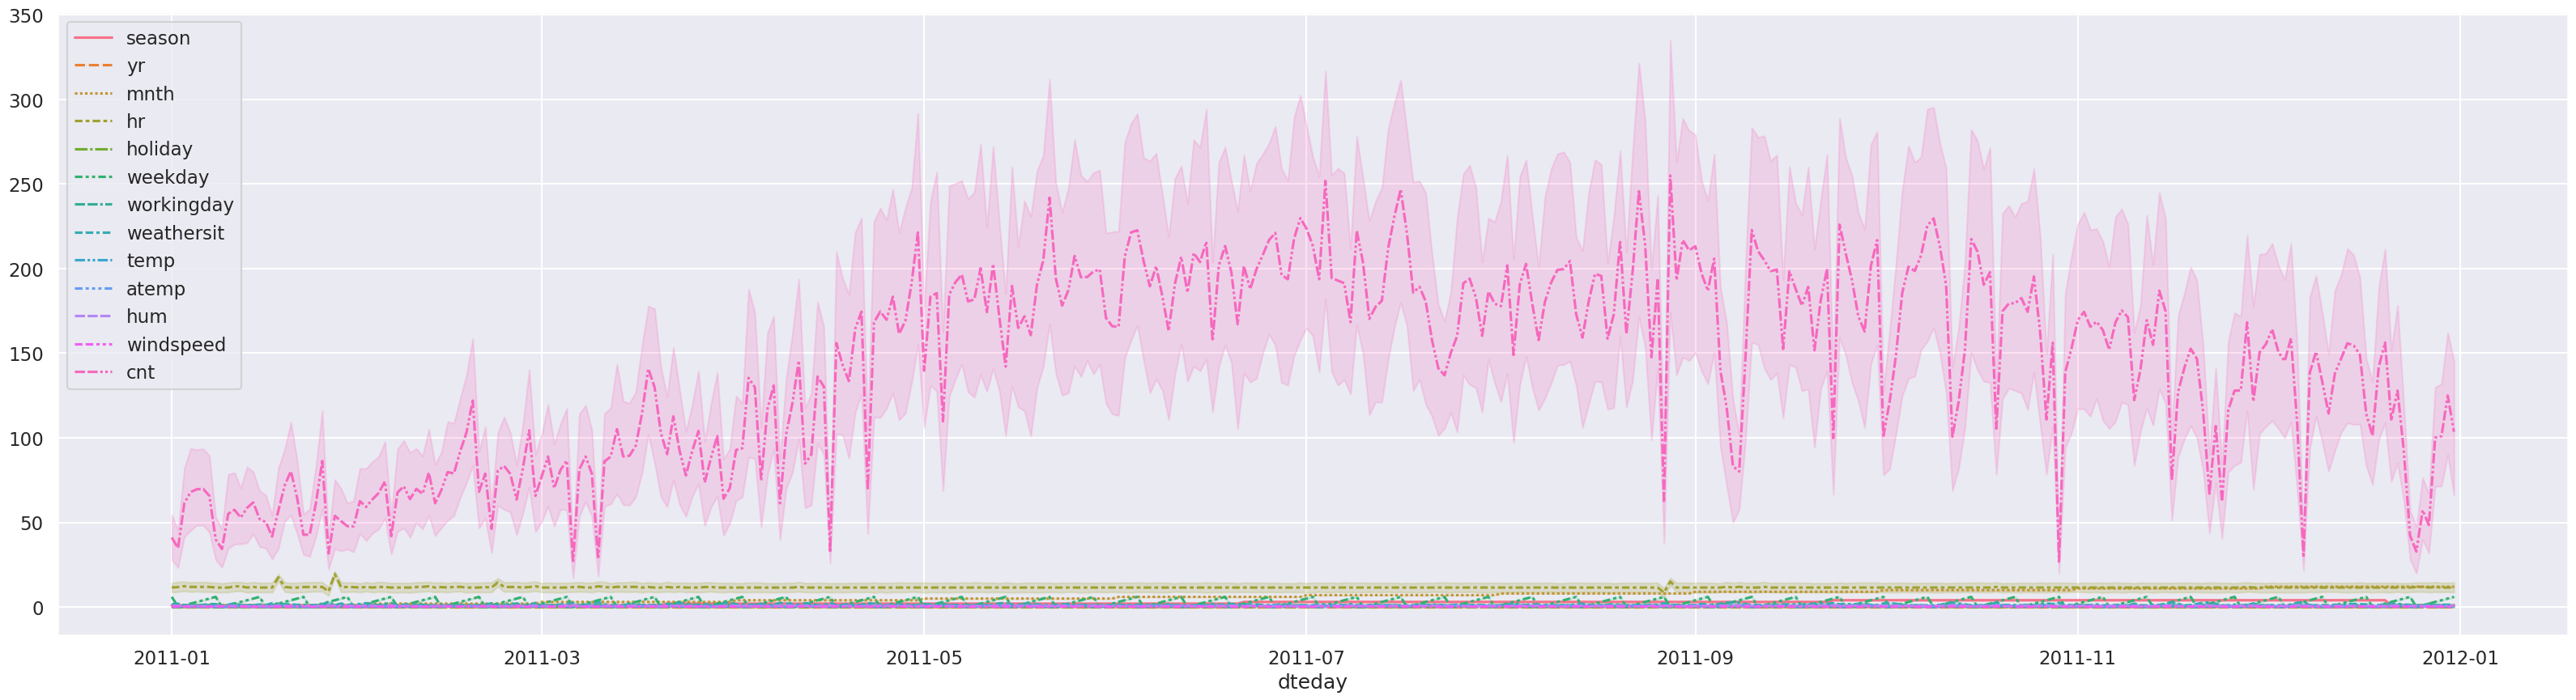

In [15]:
#折れ線グラフ

#見やすくする設定
sns.set(context='talk',font='Hiragino Maru Gothic Pro')
fig = plt.subplots(figsize=(40,10))

#全ての日時のデータを表示 
sns.lineplot(data=train_df)

細かすぎてよくわからない。

<AxesSubplot:xlabel='dteday', ylabel='cnt'>

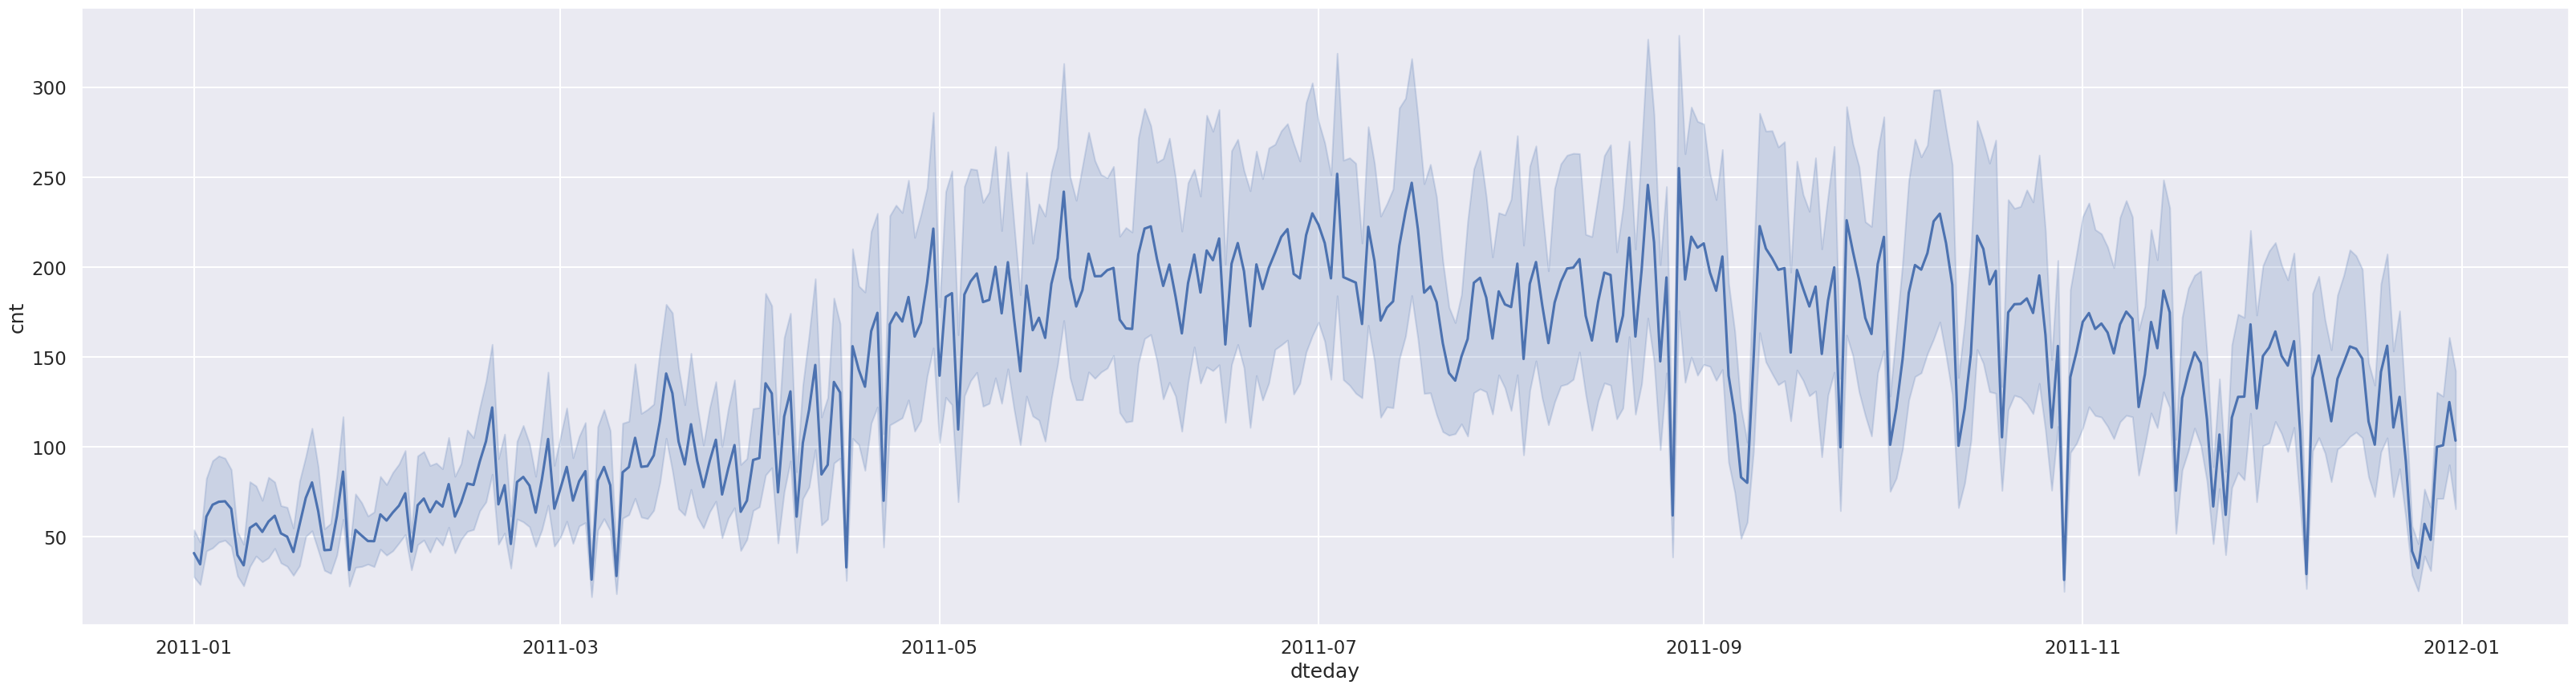

In [19]:
#折れ線グラフ

#見やすくする設定
sns.set(context='talk',font='Hiragino Maru Gothic Pro')
fig = plt.subplots(figsize=(40,10))

#全ての日時を表示 
sns.lineplot(data=train_df['cnt'])

なんとなく周期性が見られる。  
5月からの利用は利用者が増えている。  

#### 期間ごとの周期性を可視化

In [20]:
#月ごとの売上金額の合計を表示
train_month_df = train_df.set_index(train_df.index.month)

<AxesSubplot:xlabel='dteday', ylabel='cnt'>

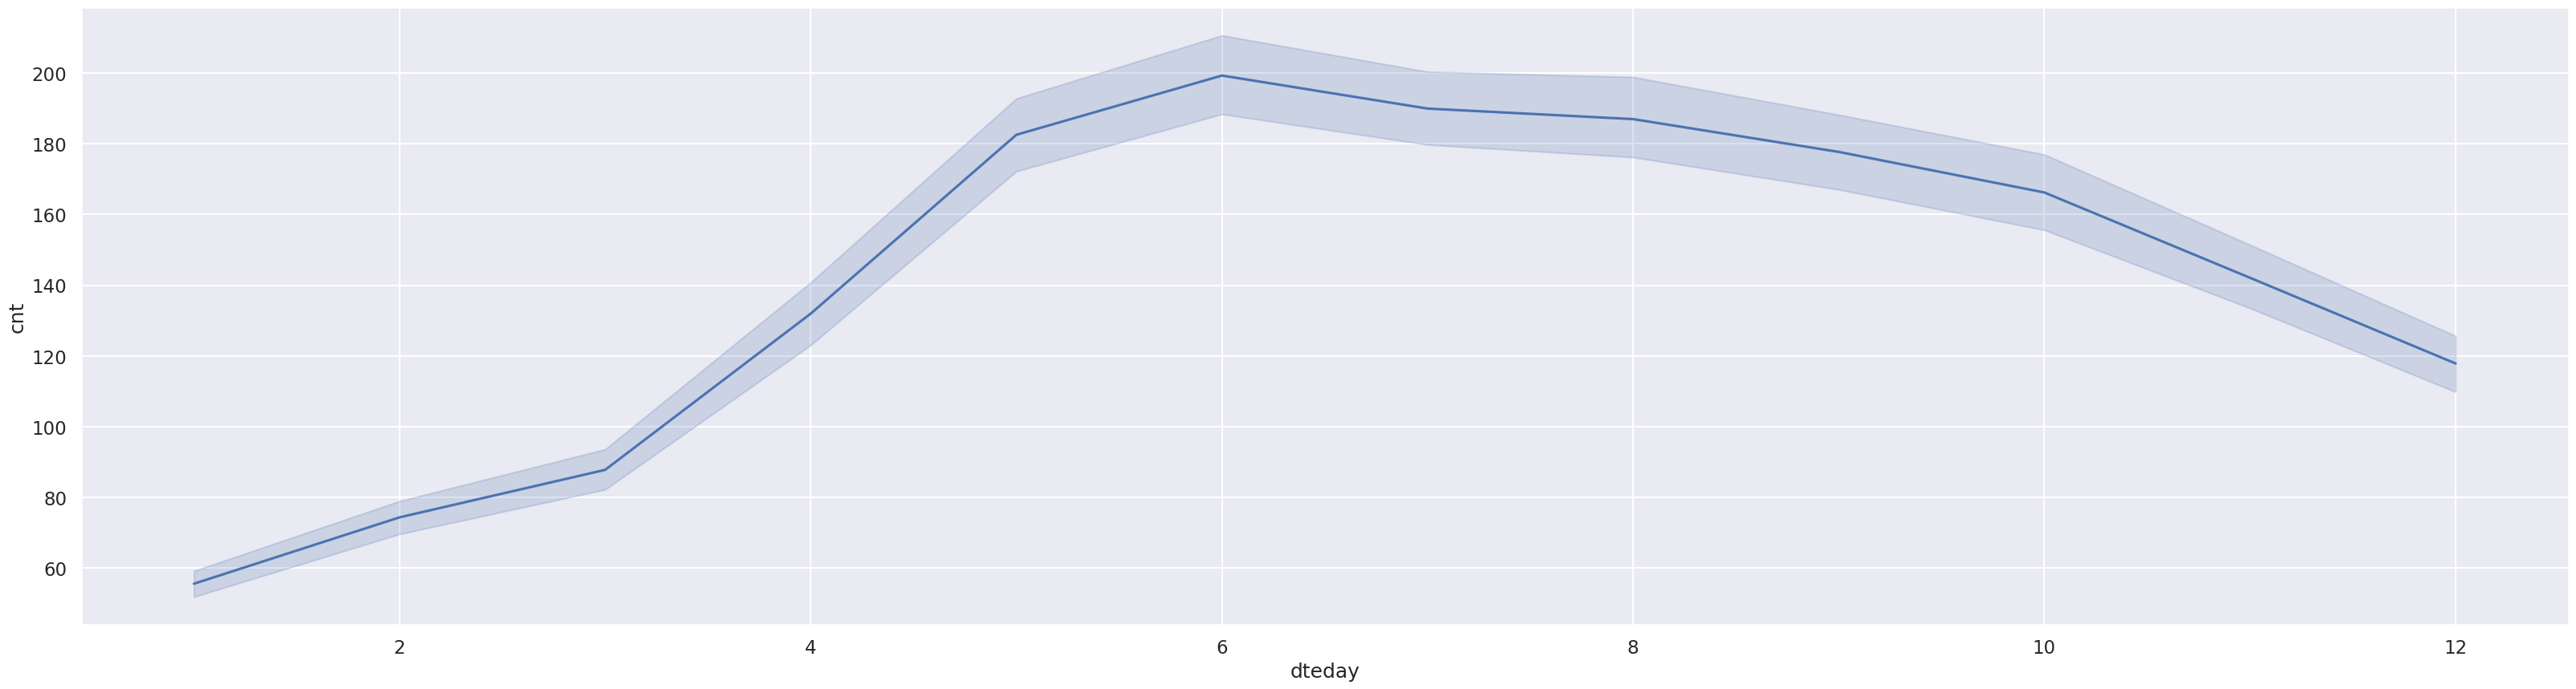

In [21]:
#折れ線グラフ

#見やすくする設定
sns.set(context='talk',font='Hiragino Maru Gothic Pro')
fig = plt.subplots(figsize=(40,10))

#月ごとの利用者数を表示 
sns.lineplot(data=train_month_df['cnt'])

In [29]:
#月ごとの合計、平均、最大値、最小値
train_df.resample('M').agg(['sum','mean','max','min']).head()

season                    yr               mnth                 hr  \
              sum      mean max min sum mean max min   sum mean max min   sum   
dteday                                                                          
2011-01-31    688  1.000000   1   1   0  0.0   0   0   688  1.0   1   1  8168   
2011-02-28    649  1.000000   1   1   0  0.0   0   0  1298  2.0   2   2  7649   
2011-03-31    990  1.356164   2   1   0  0.0   0   0  2190  3.0   3   3  8506   
2011-04-30   1438  2.000000   2   2   0  0.0   0   0  2876  4.0   4   4  8277   
2011-05-31   1488  2.000000   2   2   0  0.0   0   0  3720  5.0   5   5  8556   

                              holiday                   weekday                \
                 mean max min     sum      mean max min     sum      mean max   
dteday                                                                          
2011-01-31  11.872093  23   0      24  0.034884   1   0    2018  2.933140   6   
2011-02-28  11.785824  23   0      24  0.036980   1   0    1957  3.015408   6   
2011-03-31  11.652055  23   0       0  0.000000   0   0    2202  3.016438   6   
2011-04-30  11.511822  23   0      24  0.033380   1   0    2279  3.169680   6   
2011-05-31  11.500000  23   0      24  0.032258   1   0    2088  2.806452   6   

               workingday                   weathersit                    \
           min        sum      mean max min        sum      mean max min   
dteday                                                                     
2011-01-31   0        429  0.623547   1   0       1014  1.473837   4   1   
2011-02-28   0        436  0.671803   1   0        944  1.454545   3   1   
2011-03-31   0        541  0.741096   1   0       1135  1.554795   3   1   
2011-04-30   0        479  0.666203   1   0       1120  1.557719   3   1   
2011-05-31   0        504  0.677419   1   0       1065  1.431452   3   1   

              temp                           atemp                            \
               sum      mean   max   min       sum      mean     max     min   
dteday                                                                         
2011-01-31  135.82  0.197413  0.46  0.02  140.1854  0.203758  0.4545  0.0000   
2011-02-28  184.30  0.283975  0.66  0.06  185.4385  0.285730  0.6212  0.0758   
2011-03-31  241.80  0.331233  0.70  0.12  237.1618  0.324879  0.6364  0.0909   
2011-04-30  338.66  0.471015  0.76  0.24  328.3127  0.456624  0.6667  0.2273   
2011-05-31  429.46  0.577231  0.90  0.34  409.8053  0.550814  0.8333  0.3030   

               hum                      windspeed                         \
               sum      mean  max   min       sum      mean     max  min   
dteday                                                                     
2011-01-31  394.95  0.574055  1.0  0.21  135.8697  0.197485  0.5821  0.0   
2011-02-28  363.25  0.559707  1.0  0.08  148.9139  0.229451  0.8060  0.0   
2011-03-31  416.14  0.570055  1.0  0.00  169.5245  0.232225  0.6418  0.0   
2011-04-30  480.45  0.668220  1.0  0.22  175.5113  0.244105  0.6119  0.0   
2011-05-31  530.74  0.713360  1.0  0.24  134.8680  0.181274  0.6119  0.0   

               cnt                       
               sum        mean  max min  
dteday                                   
2011-01-31   38189   55.507267  249   1  
2011-02-28   48215   74.291217  327   1  
2011-03-31   64045   87.732877  336   1  
2011-04-30   94870  131.947149  530   1  
2011-05-31  135821  182.555108  611   1

In [36]:
#曜日ごとの売上金額の合計を表示
train_week_df = train_df.set_index(train_df.index.weekday)

#index名を曜日番号に変更
train_week_df.index.name = '曜日番号'

#各曜日の平均を表示
train_week_df.mean(level='曜日番号').sort_index()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
曜日番号,,,,,,,,,,,,,
0,2.528745,0.0,6.485020,11.590283,0.135223,1.0,0.864777,1.404858,0.498397,0.477759,0.646065,0.183908,145.927935
1,2.569558,0.0,6.621931,11.658756,0.000000,2.0,1.000000,1.495908,0.505336,0.485012,0.656702,0.186964,147.576105
2,2.500407,0.0,6.602116,11.542718,0.000000,3.0,1.000000,1.567128,0.502392,0.478921,0.683124,0.195553,137.647681
3,2.506939,0.0,6.669388,11.599184,0.019592,4.0,0.980408,1.467755,0.493273,0.471010,0.618678,0.207412,142.491429
4,2.510896,0.0,6.649718,11.556094,0.038741,5.0,0.961259,1.405973,0.476110,0.457345,0.623785,0.186433,146.897498
5,2.471519,0.0,6.530063,11.467563,0.000000,6.0,0.000000,1.409019,0.466060,0.448659,0.628434,0.196112,142.201741
6,2.508530,0.0,6.461413,11.604387,0.000000,0.0,0.000000,1.314379,0.482746,0.465032,0.647782,0.181801,143.845654


<AxesSubplot:xlabel='曜日番号', ylabel='cnt'>

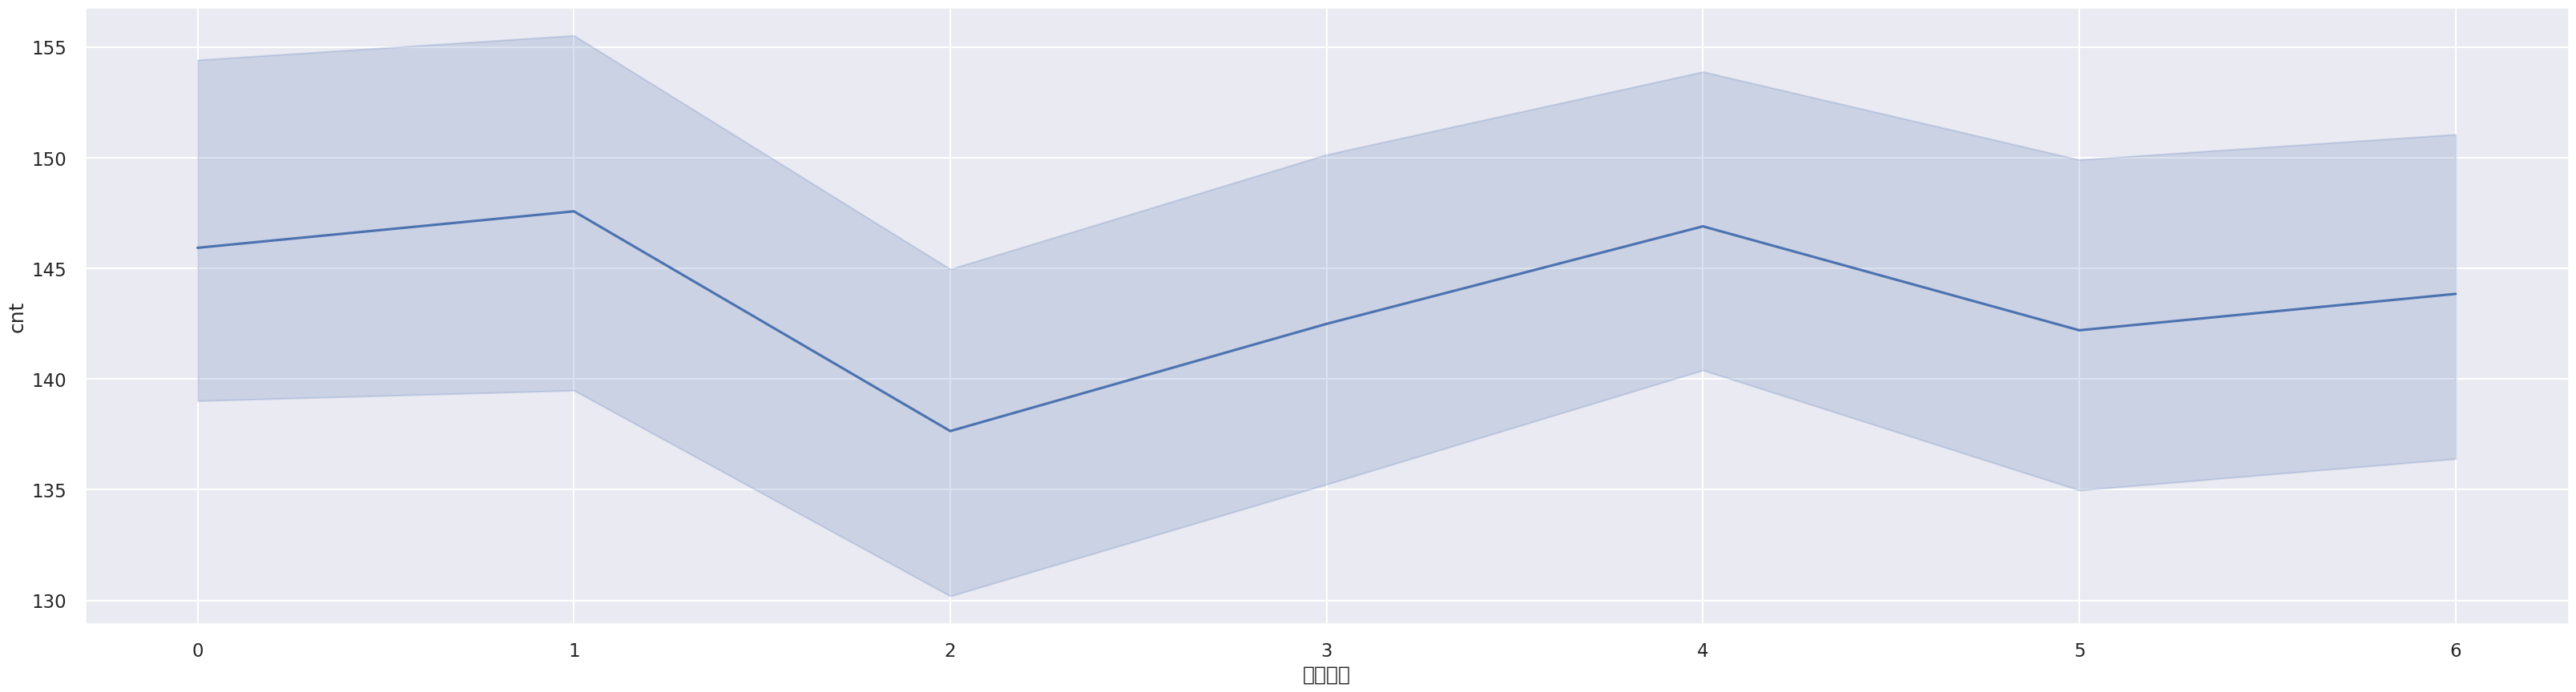

In [37]:
#折れ線グラフ

#見やすくする設定
sns.set(context='talk',font='Hiragino Maru Gothic Pro')
fig = plt.subplots(figsize=(40,10))

#曜日ごとの利用者数を表示 
sns.lineplot(data=train_week_df['cnt'])

In [55]:
#各曜日の平均を表示
train_week_df.mean(level='曜日番号').sort_index()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
曜日番号,,,,,,,,,,,,,
0,2.528745,0.0,6.485020,11.590283,0.135223,1.0,0.864777,1.404858,0.498397,0.477759,0.646065,0.183908,145.927935
1,2.569558,0.0,6.621931,11.658756,0.000000,2.0,1.000000,1.495908,0.505336,0.485012,0.656702,0.186964,147.576105
2,2.500407,0.0,6.602116,11.542718,0.000000,3.0,1.000000,1.567128,0.502392,0.478921,0.683124,0.195553,137.647681
3,2.506939,0.0,6.669388,11.599184,0.019592,4.0,0.980408,1.467755,0.493273,0.471010,0.618678,0.207412,142.491429
4,2.510896,0.0,6.649718,11.556094,0.038741,5.0,0.961259,1.405973,0.476110,0.457345,0.623785,0.186433,146.897498
5,2.471519,0.0,6.530063,11.467563,0.000000,6.0,0.000000,1.409019,0.466060,0.448659,0.628434,0.196112,142.201741
6,2.508530,0.0,6.461413,11.604387,0.000000,0.0,0.000000,1.314379,0.482746,0.465032,0.647782,0.181801,143.845654


5,6などの土曜、日曜の方が利用が多いと思ったが、曜日による違いはそんなになさそう。

<AxesSubplot:xlabel='dteday', ylabel='cnt'>

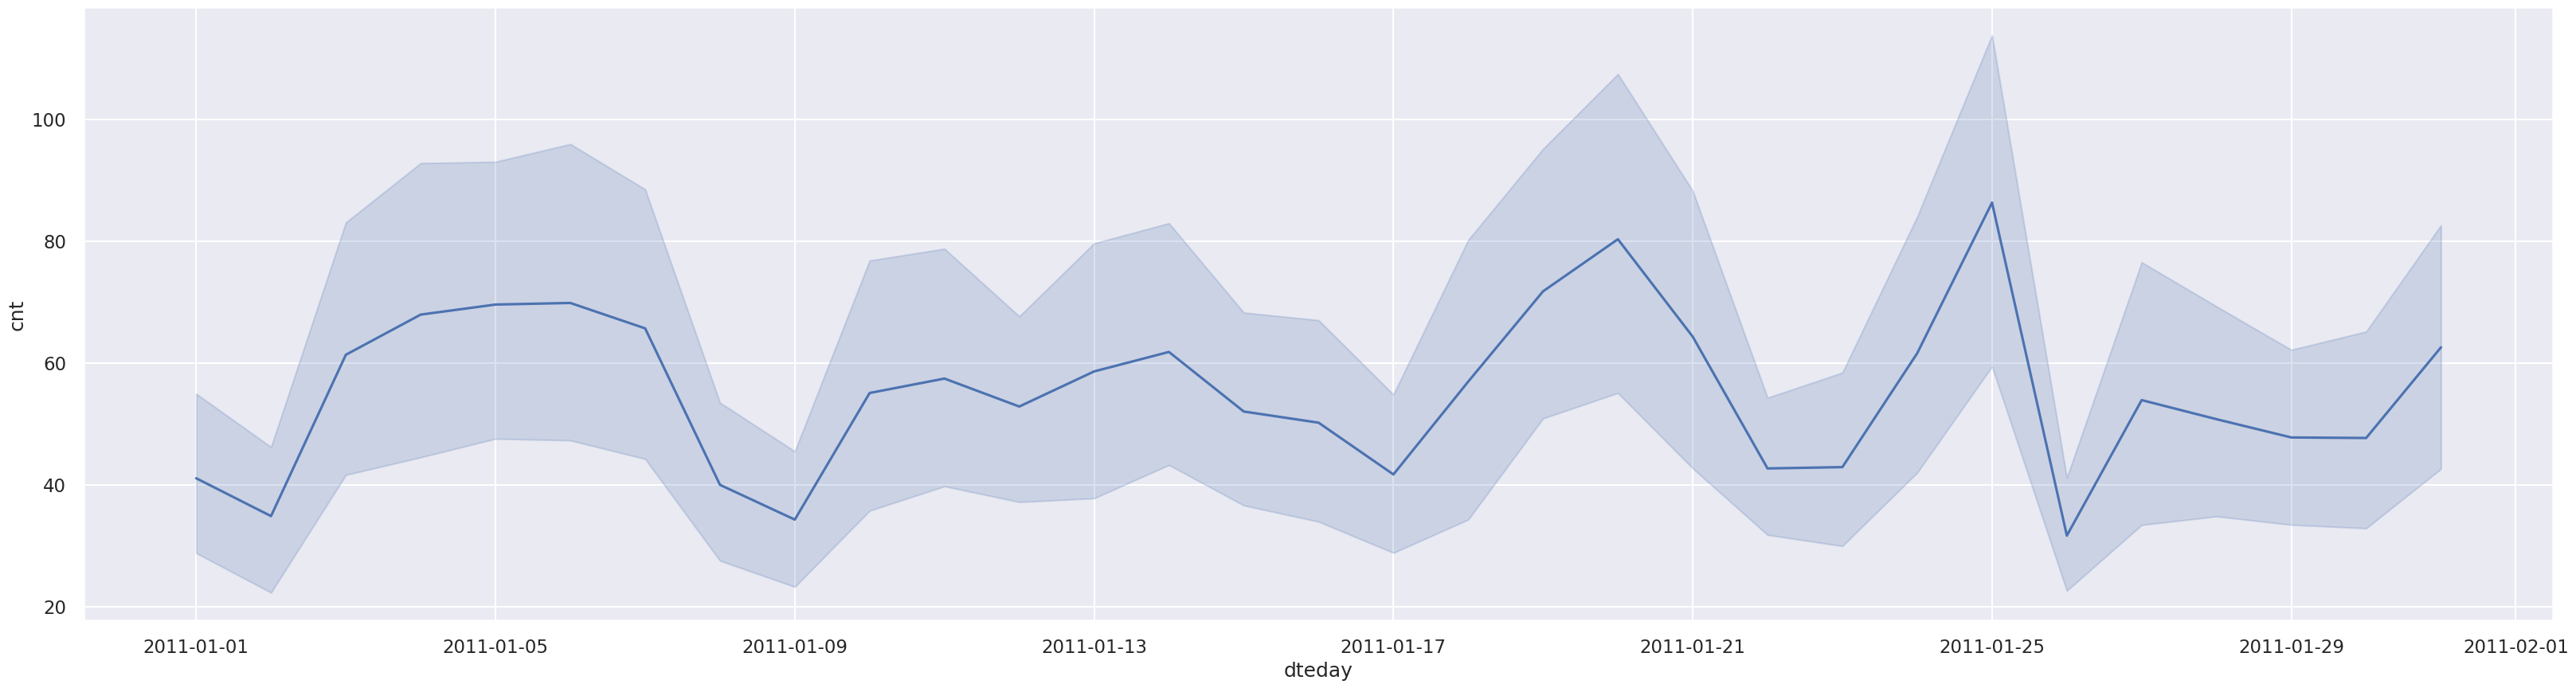

In [40]:
#折れ線グラフ

#見やすくする設定
sns.set(context='talk',font='Hiragino Maru Gothic Pro')
fig = plt.subplots(figsize=(40,10))

#2011年1月のみの利用者数を表示 
sns.lineplot(data=train_df['cnt']['2011-01'])

### idごとで可視化

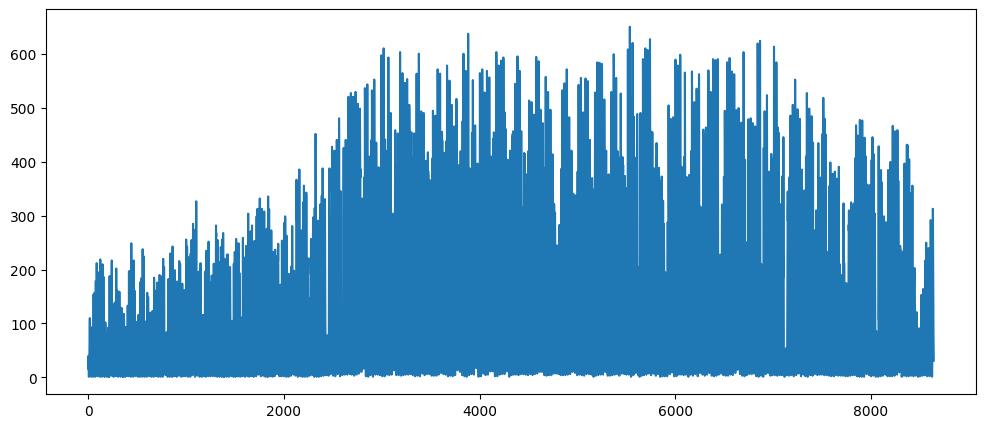

In [60]:
# 利用状況をプロットしてみる
train_df = pd.read_table('train.tsv')
plt.figure(figsize=(12,5))
plt.plot(train_df['id'],train_df['cnt'])

id2500以前は傾向が違う。  
レンタル自転車数を増やしたのか

In [44]:
train_df[2497:]

,id,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
2497,2498,2011-04-18,2,0,4,23,0,1,1,1,0.50,0.4848,0.59,0.2537,46
2498,2499,2011-04-19,2,0,4,0,0,2,1,1,0.50,0.4848,0.55,0.2239,25
2499,2500,2011-04-19,2,0,4,1,0,2,1,1,0.46,0.4545,0.63,0.2239,7
2500,2501,2011-04-19,2,0,4,2,0,2,1,1,0.46,0.4545,0.67,0.2836,13
2501,2502,2011-04-19,2,0,4,3,0,2,1,1,0.48,0.4697,0.63,0.2239,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8640,8641,2011-12-31,1,0,12,19,0,6,0,1,0.42,0.4242,0.54,0.2239,92
8641,8642,2011-12-31,1,0,12,20,0,6,0,1,0.42,0.4242,0.54,0.2239,71
8642,8643,2011-12-31,1,0,12,21,0,6,0,1,0.40,0.4091,0.58,0.1940,52
8643,8644,2011-12-31,1,0,12,22,0,6,0,1,0.38,0.3939,0.62,0.1343,38


### 相関関係

In [61]:
train_df.corr()[['cnt']]

,cnt
id,0.178084
season,0.221719
yr,NaN
mnth,0.179273
hr,0.407486
holiday,-0.022912
weekday,-0.004321
workingday,0.011704
weathersit,-0.143288
temp,0.451233


cntはhrと正の相関  
atempと正の相関  
hum(湿度)と負の相関  
→時間が遅くて、気温が高く、湿度が低いと利用者は増える。

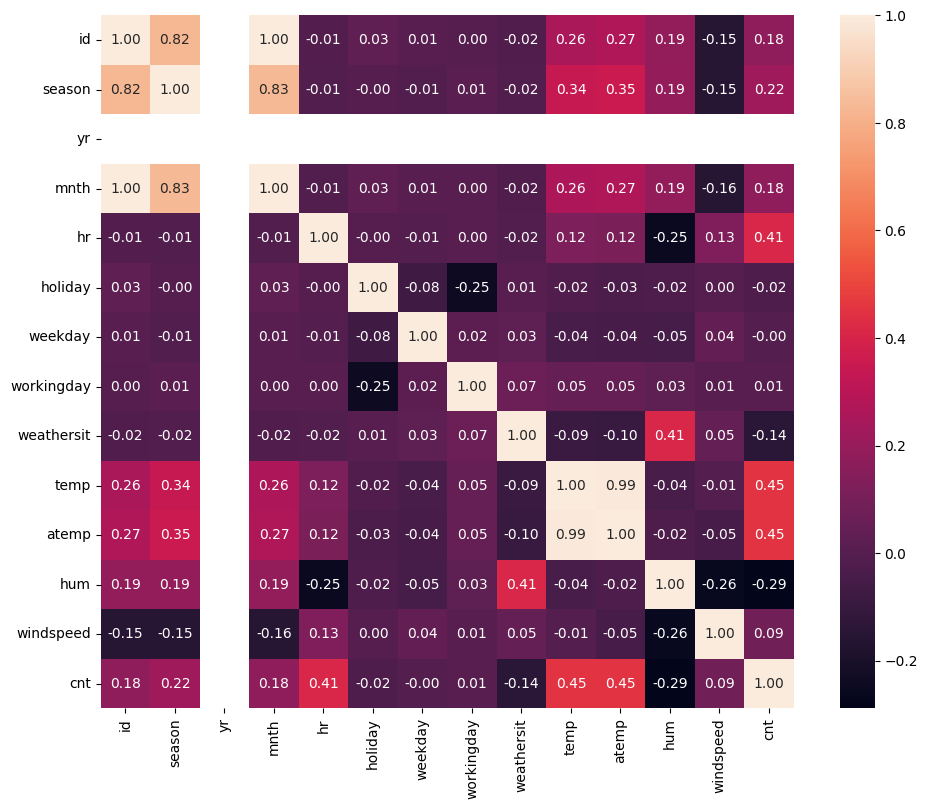

In [62]:
plt.figure(figsize=(12, 9))
sns.heatmap(train_df.corr(), annot=True, square=True, fmt='.2f')
plt.show()

### 相関関係を踏まえて、改めてクロス集計

#### 利用時間と曜日に絞って、表示

<AxesSubplot:xlabel='hr'>

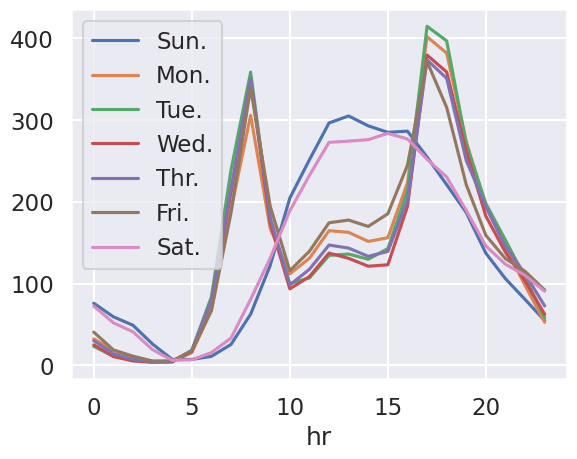

In [27]:
#各時間と曜日にまとめて、その平均を取る。
p_table2 = pd.pivot_table(data=train_df.loc[:,['cnt','weekday','hr']], index = 'hr', columns = 'weekday', aggfunc='mean')

#indexを時間、columnを曜日
p_table2.columns=['Sun.','Mon.','Tue.','Wed.','Thr.','Fri.','Sat.']
p_table2.plot()

In [17]:
p_table3 = pd.pivot_table(data=train_df.loc[:,['cnt','weekday','hr']], index = 'weekday', columns = 'hr', aggfunc='mean')

#indexを曜日、columnを時間
p_table3.index=['Sun.','Mon.','Tue.','Wed.','Thr.','Fri.','Sat.']
p_table3

cnt                                                        \
hr           0          1          2          3         4          5    
Sun.  76.058824  59.509804  49.080000  26.078431  7.306122   7.288889   
Mon.  32.480769  18.000000  10.234043   5.270833  5.083333  15.634615   
Tue.  23.280000  11.244898   6.520000   4.022222  4.750000  18.540000   
Wed.  25.134615  10.846154   5.420000   3.808511  4.173913  17.000000   
Thr.  30.196078  14.156863   7.340000   4.541667  4.520833  18.372549   
Fri.  40.711538  18.961538  11.288462   5.220000  5.422222  17.653846   
Sat.  72.528302  52.150943  41.037736  19.226415  6.301887   6.862745   

                                                                             \
hr           6           7           8           9           10          11   
Sun.  11.060000   25.634615   62.615385  122.384615  204.788462  251.615385   
Mon.  67.538462  190.403846  305.980769  167.384615  111.961538  131.153846   
Tue.  83.882353  238.941176  358.843137  177.274510  100.019608  107.058824   
Wed.  78.634615  211.173077  348.384615  174.288462   93.634615  108.634615   
Thr.  79.529412  216.666667  351.529412  181.137255   98.470588  117.588235   
Fri.  67.038462  186.634615  339.884615  194.557692  115.865385  139.711538   
Sat.  15.603774   33.471698   80.773585  131.301887  189.113208  232.509434   

                                                                              \
hr            12          13          14          15          16          17   
Sun.  296.673077  305.211538  293.115385  285.153846  286.634615  254.942308   
Mon.  164.846154  162.788462  151.711538  156.250000  223.173077  402.096154   
Tue.  134.596154  136.250000  129.884615  142.903846  213.403846  414.942308   
Wed.  137.442308  130.980769  121.346154  123.096154  194.288462  379.750000   
Thr.  147.274510  143.529412  133.450980  139.411765  201.826923  373.846154   
Fri.  174.538462  177.788462  170.019231  185.538462  244.826923  371.769231   
Sat.  272.943396  274.377358  276.226415  283.905660  277.094340  252.264151   

                                                                             
hr            18          19          20          21          22         23  
Sun.  221.153846  187.019231  137.230769  106.057692   80.673077  54.807692  
Mon.  382.115385  273.807692  194.230769  144.884615   97.788462  52.750000  
Tue.  397.096154  271.134615  198.038462  153.269231  107.557692  58.500000  
Wed.  358.960784  261.764706  182.588235  138.372549  103.372549  62.509804  
Thr.  351.211538  250.750000  194.269231  145.634615  111.903846  72.730769  
Fri.  315.596154  221.076923  159.096154  130.576923  115.076923  92.192308  
Sat.  230.480769  189.519231  146.096154  123.769231  110.173077  90.711538

土曜と、日曜で利用者が異なる。祝日の利用日を多いはず。  
train,testデータの祝日に対応する日を日曜として保管してもいいかも

### カテゴリ変数の('weathersit')をダミー変数に変換する。

In [119]:
train_df.dtypes

id              int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
cnt             int64
dtype: object

天気('weathersit')は  
1=晴,やや曇り  
2=薄い霧+曇り,霧+千切れ曇,霧+やや曇り,薄い霧  
3=小雪,小雨+雷雨+千切れ曇,小雨+千切れ曇  
4=大雨+凍雨+雷雨+霧,雪+濃い霧  
というデータ構成になっています。データ形式は整数(int)ですが、そのまま投入しても意味がありません。1から4をそれぞれゼロイチ(0,1)の2値にしてダミー変数にします。

In [120]:
#One-Hot Encoding
train_df_one_hot_encoded = pd.get_dummies(train_df,columns=['weathersit'])

In [133]:
train_df_one_hot_encoded.head()

,id,dteday,season,yr,mnth,hr,holiday,weekday,workingday,temp,atemp,hum,windspeed,cnt,weathersit_1,weathersit_2,weathersit_3
2500,2501,2011-04-19,2,0,4,2,0,2,1,0.46,0.4545,0.67,0.2836,13,1,0,0
2501,2502,2011-04-19,2,0,4,3,0,2,1,0.48,0.4697,0.63,0.2239,3,1,0,0
2502,2503,2011-04-19,2,0,4,4,0,2,1,0.46,0.4545,0.67,0.0896,5,1,0,0
2503,2504,2011-04-19,2,0,4,5,0,2,1,0.46,0.4545,0.72,0.1940,18,0,1,0
2504,2505,2011-04-19,2,0,4,6,0,2,1,0.48,0.4697,0.67,0.0000,65,0,1,0


In [129]:
train_df['weathersit'].value_counts()

1    4180
2    1439
3     526
Name: weathersit, dtype: int64

In [130]:
test_df['weathersit'].value_counts()

1    5768
2    2326
3     638
4       2
Name: weathersit, dtype: int64

trainデータには大雨の4は無いが、testデータにはあるので、  
testでは、4を3に補完したうえで、ダミー変数に変換してやる。

# 検証1

### 回帰分析

In [20]:
#前処理

#trainデータ処理
train_df = pd.read_table('train.tsv')
#One-Hot Encoding
train_df_one_hot_encoded = pd.get_dummies(train_df,columns=['weathersit'])
# id2500以前は、傾向が違うため、カット(運用開始など？)
train_df_one_hot_encoded = train_df_one_hot_encoded[train_df_one_hot_encoded['id'] > 2500]

#testデータ処理
test_df = pd.read_table('test.tsv')
#One-Hot Encoding
test_df_one_hot_encoded = pd.get_dummies(test_df,columns=['weathersit'])


In [21]:
train_df_one_hot_encoded.head()

,id,dteday,season,yr,mnth,hr,holiday,weekday,workingday,temp,atemp,hum,windspeed,cnt,weathersit_1,weathersit_2,weathersit_3,weathersit_4
2500,2501,2011-04-19,2,0,4,2,0,2,1,0.46,0.4545,0.67,0.2836,13,1,0,0,0
2501,2502,2011-04-19,2,0,4,3,0,2,1,0.48,0.4697,0.63,0.2239,3,1,0,0,0
2502,2503,2011-04-19,2,0,4,4,0,2,1,0.46,0.4545,0.67,0.0896,5,1,0,0,0
2503,2504,2011-04-19,2,0,4,5,0,2,1,0.46,0.4545,0.72,0.1940,18,0,1,0,0
2504,2505,2011-04-19,2,0,4,6,0,2,1,0.48,0.4697,0.67,0.0000,65,0,1,0,0


In [22]:
train_df_one_hot_encoded.shape

(6145, 18)

In [23]:
#説明変数と目的変数を用意
#season,yr,mmth,holiday,weekday,workingday
X = train_df_one_hot_encoded[['hr','temp','atemp','weathersit_1','weathersit_2','weathersit_3']]
y = train_df_one_hot_encoded['cnt']

In [24]:
from sklearn.linear_model import LinearRegression as LR
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

In [25]:
# train dataをtrain dataとtest dataに分けます。
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=42, shuffle=False)

# 線形回帰モデルを作成する（実はこれは機械学習です）
model = LR()

# trainの説明変数('train_X')と目的変数('train_y')をモデルに投入します。
model.fit(train_X, train_y)

# モデルの精度を確認します。
model.score(test_X, test_y)

0.1552923152694876

精度0.1552923152694874,,,
あまり高くはない。

In [144]:
test_X.shape,test_y.shape

((1537, 6), (1537,))

In [145]:
#trainデータの予測
y_test_pred = model.predict(test_X)
y_test_pred.shape

(1537,)

In [147]:
from sklearn.metrics import mean_squared_error
# RMSE計算
rmse = np.sqrt(mean_squared_error(y_test_pred, test_y))
print('RMSE : {:.3f}'.format(rmse))


RMSE : 106.637


### 提出ファイルの作成

In [148]:
#testデータの説明変数と目的変数を用意
#season,yr,mmth,holiday,weekday,workingday
X_test = test_df_one_hot_encoded[['hr','temp','atemp','weathersit_1','weathersit_2','weathersit_3']]
y_test_pred = model.predict(X_test)

In [149]:
y_test_pred

array([  9.90390065,  22.0856467 ,  19.85058967, ..., 195.79440279,
       204.47474736, 214.31965498])

In [150]:
sub = test_df.copy()
sub['cnt'] = y_test_pred
sub.head(5)

,id,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,8646,2012-01-01,1,1,1,0,0,0,0,1,0.36,0.3788,0.66,0.0000,9.903901
1,8647,2012-01-01,1,1,1,1,0,0,0,1,0.36,0.3485,0.66,0.1343,22.085647
2,8648,2012-01-01,1,1,1,2,0,0,0,1,0.32,0.3485,0.76,0.0000,19.850590
3,8649,2012-01-01,1,1,1,3,0,0,0,1,0.30,0.3333,0.81,0.0000,24.827790
4,8650,2012-01-01,1,1,1,4,0,0,0,1,0.28,0.3030,0.81,0.0896,30.969554


In [151]:
# 提出ファイル
sub[['id','cnt']].to_csv('sample_submit_02.csv', index=False, header = False)

In [152]:
sample_submit_02 = pd.read_csv('sample_submit_02.csv')
sample_submit_02.head(5)

,8646,9.90390064677537
0,8647,22.085647
1,8648,19.850590
2,8649,24.827790
3,8650,30.969554
4,8651,41.979025


### 評価  
RMSE  194.3392590(125/1246位)  
精度は高いとは言えない、  
特徴量を加えたり、別の学習モデルやアンサンブル学習などいろいろ出来そう。

# 検証2

### Deep learning  
## RNN

目的変数・・・利用者('cnt')  
説明変数・・・hr,workday,曜日('weekday')、温度('temp')、体感温度('atemp')、天気('weathersit')    
cntと相関関係のある変数を使う

In [153]:
#前処理

#trainデータ処理
train_df = pd.read_table('train.tsv')
#One-Hot Encoding
train_df_one_hot_encoded = pd.get_dummies(train_df,columns=['weathersit'])
#曜日の'weekday'を土日(0)と平日(1)の2値データする。
#新しい変数'weekday2'を作って、全て0(zero)を入れる
train_df_one_hot_encoded['weekday2'] = 0
#平日を1にしたいので、1にするコードを用意する
train_df_one_hot_encoded.loc[train_df_one_hot_encoded['weekday'].isin(list(range(1,6))),'weekday2']=1
# 結果の件数を確認する
#train_df_one_hot_encoded['weekday2'].value_counts()
# id2500以前は、傾向が違うため、カット(運用開始など？)
train_df_one_hot_encoded = train_df_one_hot_encoded[train_df_one_hot_encoded['id'] > 2500]


#testデータ処理
test_df = pd.read_table('test.tsv')
#One-Hot Encoding
test_df_one_hot_encoded = pd.get_dummies(test_df,columns=['weathersit'])
#曜日の'weekday'を土日(0)と平日(1)の2値データする。
#新しい変数'weekday2'を作って、全て0(zero)を入れる
test_df_one_hot_encoded['weekday2'] = 0
#平日を1にしたいので、1にするコードを用意する
test_df_one_hot_encoded.loc[test_df_one_hot_encoded['weekday'].isin(list(range(1,6))),'weekday2']=1


In [154]:
train_df_one_hot_encoded['weekday2'].value_counts()

1    4407
0    1738
Name: weekday2, dtype: int64

In [156]:
train_df_one_hot_encoded.head()

,id,dteday,season,yr,mnth,hr,holiday,weekday,workingday,temp,atemp,hum,windspeed,cnt,weathersit_1,weathersit_2,weathersit_3,weathersit_4,weekday2
2500,2501,2011-04-19,2,0,4,2,0,2,1,0.46,0.4545,0.67,0.2836,13,1,0,0,0,1
2501,2502,2011-04-19,2,0,4,3,0,2,1,0.48,0.4697,0.63,0.2239,3,1,0,0,0,1
2502,2503,2011-04-19,2,0,4,4,0,2,1,0.46,0.4545,0.67,0.0896,5,1,0,0,0,1
2503,2504,2011-04-19,2,0,4,5,0,2,1,0.46,0.4545,0.72,0.1940,18,0,1,0,0,1
2504,2505,2011-04-19,2,0,4,6,0,2,1,0.48,0.4697,0.67,0.0000,65,0,1,0,0,1


必要なモジュールをインポート

In [157]:
import matplotlib.pyplot as plt
#tensorflowを用いる。
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Input, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

説明変数xと目的変数yを準備する。  

In [158]:
#必要な説明変数だけをとりだす
train_df_x = train_df_one_hot_encoded[['hr','workingday','weekday2','temp','atemp','weathersit_1','weathersit_2','weathersit_3']]
train_df_y = train_df_one_hot_encoded['cnt']
train_df_x.head()

,hr,workingday,weekday2,temp,atemp,weathersit_1,weathersit_2,weathersit_3
2500,2,1,1,0.46,0.4545,1,0,0
2501,3,1,1,0.48,0.4697,1,0,0
2502,4,1,1,0.46,0.4545,1,0,0
2503,5,1,1,0.46,0.4545,0,1,0
2504,6,1,1,0.48,0.4697,0,1,0


In [159]:
# defaultはtrain dataが75%、test dataが25%に分割されます。
# また時系列のデータなので、shuffleをFalseにします。
train_X, test_X, train_y, test_y = train_test_split(train_df_x, train_df_y, random_state=42, shuffle=False)

# input_dimに説明変数の数を入れます。
# Denseで層を設定します。
model = Sequential()
model.add(Dense(256, input_dim=8, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5)) #128のNordを50%落とす
model.add(Dense(1))

# 損失関数にmse、最適化関数にadamを採用
model.compile(loss='mse', optimizer='adam')

# モデルを学習させます
# epochsは学習回数24回(1時間ごとのデータで、24回で一日分のため)
#データ数(6483) x 学習回数
# batch_size データ数(6483)を細かく分ける
train_model = model.fit(train_X, train_y, epochs= 60, batch_size= 24, verbose=1, validation_data=(test_X, test_y))

Epoch 1/60
192/192 [==============================] - 1s 3ms/step - loss: 24023.7266 - val_loss: 15386.7480
Epoch 2/60
192/192 [==============================] - 0s 2ms/step - loss: 17070.4160 - val_loss: 14252.9111
Epoch 3/60
192/192 [==============================] - 0s 2ms/step - loss: 16554.1055 - val_loss: 14908.2822
Epoch 4/60
192/192 [==============================] - 0s 2ms/step - loss: 16440.3828 - val_loss: 12963.1143
Epoch 5/60
192/192 [==============================] - 0s 2ms/step - loss: 16084.5576 - val_loss: 13000.0713
Epoch 6/60
192/192 [==============================] - 0s 2ms/step - loss: 15554.5312 - val_loss: 11542.6846
Epoch 7/60
192/192 [==============================] - 0s 2ms/step - loss: 15315.5381 - val_loss: 10713.5918
Epoch 8/60
192/192 [==============================] - 0s 3ms/step - loss: 14699.9355 - val_loss: 11082.4219
Epoch 9/60
192/192 [==============================] - 0s 2ms/step - loss: 14448.4727 - val_loss: 10079.3633
Epoch 10/60
192/192 [=======

49/49 [==============================] - 0s 2ms/step
REG RMSE : 86.83


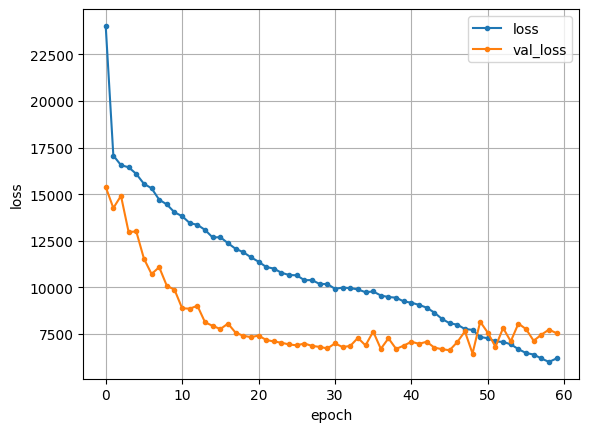

In [160]:
# 予測値を出力
y_pred = model.predict(test_X)

# 二乗誤差を出力
mse= mean_squared_error(test_y, y_pred)
print("REG RMSE : %.2f" % (mse** 0.5))

# epoch毎の予測値の正解データとの誤差を表しています
# バリデーションデータのみ誤差が大きい場合、過学習を起こしています

loss=train_model.history['loss']
val_loss=train_model.history['val_loss']
epochs=len(loss)

plt.plot(range(epochs), loss, marker = '.', label = 'loss')
plt.plot(range(epochs), val_loss, marker = '.', label = 'val_loss')
plt.legend(loc = 'best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

epoch20あたりからlossが7500あたりで停滞  
val_lossが徐々に下がっていて、なかなか良いモデル。

In [165]:
from sklearn.metrics import mean_squared_error
# RMSE計算
rmse = np.sqrt(mean_squared_error(test_y, y_pred))
print('RMSE : {:.3f}'.format(rmse))


RMSE : 86.832


わるく無さそう。

In [166]:
#testデータの必要な変数だけをとりだす
test_df_x = test_df_one_hot_encoded[['hr','workingday','weekday2','temp','atemp','weathersit_1','weathersit_2','weathersit_3']]
test_df_x.head()

,hr,workingday,weekday2,temp,atemp,weathersit_1,weathersit_2,weathersit_3
0,0,0,0,0.36,0.3788,1,0,0
1,1,0,0,0.36,0.3485,1,0,0
2,2,0,0,0.32,0.3485,1,0,0
3,3,0,0,0.30,0.3333,1,0,0
4,4,0,0,0.28,0.3030,1,0,0


In [167]:
test_df_x.shape

(8734, 8)

In [168]:
# test dataにモデルを適用する
Y_test_pred = model.predict(test_df_x) #X_testデータを使って予測する

273/273 [==============================] - 0s 2ms/step


In [169]:
Y_test_pred

array([[92.98216 ],
       [62.593594],
       [34.43942 ],
       ...,
       [93.07214 ],
       [76.33465 ],
       [62.49991 ]], dtype=float32)

### 提出ファイルの作成

In [170]:
Y_test_pred.shape,test_df.shape

((8734, 1), (8734, 14))

In [171]:
sub = test_df.copy()
sub['cnt'] = Y_test_pred
sub.head(5)

,id,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,8646,2012-01-01,1,1,1,0,0,0,0,1,0.36,0.3788,0.66,0.0000,92.982162
1,8647,2012-01-01,1,1,1,1,0,0,0,1,0.36,0.3485,0.66,0.1343,62.593594
2,8648,2012-01-01,1,1,1,2,0,0,0,1,0.32,0.3485,0.76,0.0000,34.439419
3,8649,2012-01-01,1,1,1,3,0,0,0,1,0.30,0.3333,0.81,0.0000,15.353641
4,8650,2012-01-01,1,1,1,4,0,0,0,1,0.28,0.3030,0.81,0.0896,8.348648


In [172]:
# 提出ファイル
sub[['id','cnt']].to_csv('sample_submit_03.csv', index=False, header = False)

In [173]:
sample_submit_03 = pd.read_csv('sample_submit_03.csv')
sample_submit_03.head(5)

,8646,92.98216
0,8647,62.593594
1,8648,34.439420
2,8649,15.353641
3,8650,8.348648
4,8651,7.925747


### 評価  
RMSE  143.9651463(125/1246位)  
精度は高いとは言えない、  
特徴量を加えたり、別の学習モデルやアンサンブル学習などいろいろ出来そう。

# 検証3

# 学習
## XGBoost

In [34]:
#前処理なし
train_df = pd.read_table('train.tsv')
test_df = pd.read_table('test.tsv')

In [29]:
# XGBoostのライブラリのインポート
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [5]:
# xgboostモデルの作成
reg = xgb.XGBRegressor()

In [30]:
# id2500以前は、傾向が違うため、カット(運用開始など？)
train_df = train_df[train_df['id'] > 2500]

In [31]:
# 説明変数、目的変数を格納
X_train = train_df.drop(['id','dteday','cnt'], axis=1)
y_train = train_df['cnt']
X_test = test_df.drop(['id','dteday'], axis=1)

In [118]:
# train dataをtrain dataとtest dataに分ける。
train_X, test_X, train_y, test_y = train_test_split(X_train, y_train, random_state=42, shuffle=False)


In [120]:
# ハイパーパラメータ探索
reg_cv = GridSearchCV(reg, {'max_depth': [2,4,6], 'n_estimators': [50,100,200]}, verbose=1)
reg_cv.fit(train_X, train_y)
print(reg_cv.best_params_, reg_cv.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
{'max_depth': 6, 'n_estimators': 50} 0.9023743487456599


In [121]:
# 改めて最適パラメータで学習
reg = xgb.XGBRegressor(**reg_cv.best_params_)
reg.fit(train_X, train_y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=50, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

## モデルの確認

In [123]:
# 学習データを使って予測
pred_test_y = reg.predict(test_X)

In [124]:
pred_test_y

array([259.3758 , 153.87988,  56.94194, ..., 144.47849, 103.82209,
        63.92534], dtype=float32)

<AxesSubplot: >

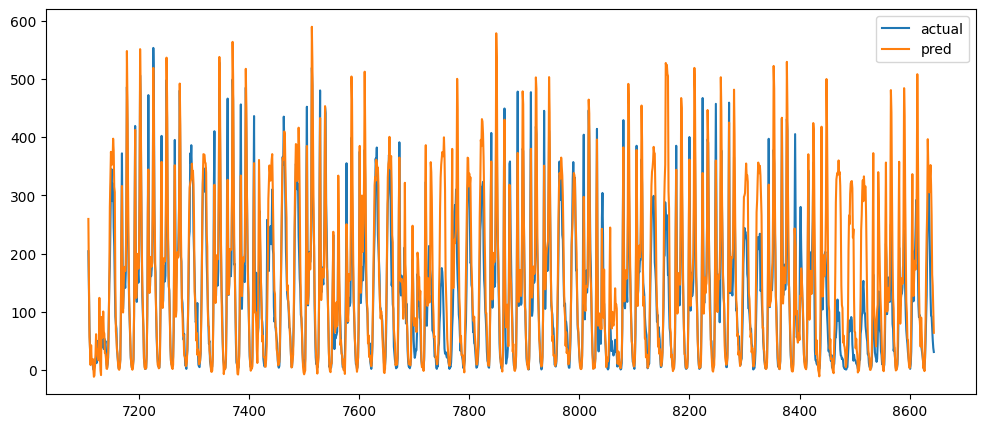

In [125]:
# 予測値が妥当か確認
train_value = y_train.values
_df = pd.DataFrame({'actual':test_y,'pred':pred_test_y})
_df.plot(figsize=(12,5))

おおむね、正しく予測出来てそう

### 特徴量の重要度確認

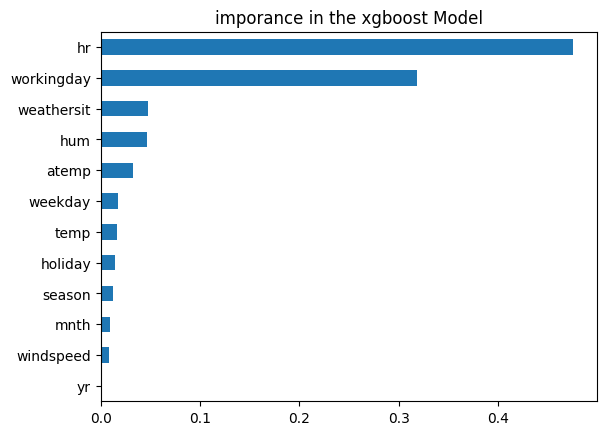

In [126]:
# feature importance のプロット
importances = pd.Series(reg.feature_importances_, index = X_train.columns)
importances = importances.sort_values()
importances.plot(kind = "barh")
plt.title("imporance in the xgboost Model")
plt.show()

時間と、曜日が大きくかかわっていることがわかる。

In [127]:
from sklearn.metrics import mean_squared_error
# RMSE計算
rmse = np.sqrt(mean_squared_error(test_y, pred_test_y))
print('RMSE : {:.3f}'.format(rmse))


RMSE : 70.500


わりと良さそう！

### 提出ファイルの作成

In [128]:
# テストデータに対し予測値の算出
pred_test = reg.predict(X_test)

In [129]:
pred_test

array([ 81.08319 ,  65.73449 ,  42.460697, ..., 122.549805,  70.946075,
        48.53842 ], dtype=float32)

In [130]:
sub = test_df.copy()
sub['cnt'] = pred_test
sub.head(5)

,id,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,8646,2012-01-01,1,1,1,0,0,0,0,1,0.36,0.3788,0.66,0.0000,81.083191
1,8647,2012-01-01,1,1,1,1,0,0,0,1,0.36,0.3485,0.66,0.1343,65.734489
2,8648,2012-01-01,1,1,1,2,0,0,0,1,0.32,0.3485,0.76,0.0000,42.460697
3,8649,2012-01-01,1,1,1,3,0,0,0,1,0.30,0.3333,0.81,0.0000,26.842190
4,8650,2012-01-01,1,1,1,4,0,0,0,1,0.28,0.3030,0.81,0.0896,8.683386


In [131]:
# 提出ファイル
sub[['id','cnt']].to_csv('sample_submit_01.csv', index=False, header = False)

In [132]:
sample_submit_01 = pd.read_csv('sample_submit_01.csv')
sample_submit_01.head(5)

,8646,81.08319
0,8647,65.734490
1,8648,42.460697
2,8649,26.842190
3,8650,8.683386
4,8651,8.956017


### 評価  
RMSE  119.0302645(125/1246位)  
→少し調節して、113.7184399に
最初にしては悪くない精度、  
特徴量を加えたり、別の学習モデルやアンサンブル学習などいろいろ出来そう。

# 検証 4

## スタッキング(ランダムフォレスト,lightgbm,xgboostの予測値を重回帰分析にかけて最終的な予測をする。)

In [59]:
#前処理

#trainデータ処理
train_df = pd.read_table('train.tsv')
#One-Hot Encoding
train_df_one_hot_encoded = pd.get_dummies(train_df,columns=['weathersit'])
#曜日の'weekday'を土日(0)と平日(1)の2値データする。
#新しい変数'weekday2'を作って、全て0(zero)を入れる
train_df_one_hot_encoded['weekday2'] = 0
#平日を1にしたいので、1にするコードを用意する
train_df_one_hot_encoded.loc[train_df_one_hot_encoded['weekday'].isin(list(range(1,6))),'weekday2']=1
# 結果の件数を確認する
#train_df_one_hot_encoded['weekday2'].value_counts()
# id2500以前は、傾向が違うため、カット(運用開始など？)
train_df_one_hot_encoded = train_df_one_hot_encoded[train_df_one_hot_encoded['id'] > 2500]


#testデータ処理
test_df = pd.read_table('test.tsv')
#One-Hot Encoding
test_df_one_hot_encoded = pd.get_dummies(test_df,columns=['weathersit'])
#曜日の'weekday'を土日(0)と平日(1)の2値データする。
#新しい変数'weekday2'を作って、全て0(zero)を入れる
test_df_one_hot_encoded['weekday2'] = 0
#平日を1にしたいので、1にするコードを用意する
test_df_one_hot_encoded.loc[test_df_one_hot_encoded['weekday'].isin(list(range(1,6))),'weekday2']=1


In [60]:
# 説明変数、目的変数を格納
X = train_df_one_hot_encoded.drop(['id','dteday','cnt'], axis=1)
y = train_df_one_hot_encoded['cnt']


第一段階での予測値を利用して、さらに重回帰分析をするので、データを三分割する必要がある。

In [61]:
# データを3つに分割
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(3932, 16)
(984, 16)
(1229, 16)
(3932,)
(984,)
(1229,)


In [63]:
from sklearn.ensemble import RandomForestRegressor #ランダムフォレスト 

In [64]:
# モデルのインスタンス
# xgboostモデルの作成
model_1 = xgb.XGBRegressor()
model_2 = RandomForestRegressor()
model_3 = lgb.LGBMRegressor()

# モデルの学習
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)

# 予測値の作成
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)


In [65]:
#　各モデル個別の予測精度をRMSEで確認
rmse_1 = np.sqrt(mean_squared_error(y_test, pred_1))
print('XGBoostのRMSE : {:.3f}'.format(rmse_1))

rmse_2 = np.sqrt(mean_squared_error(y_test, pred_2))
print('ランダムフォレストのRMSE : {:.3f}'.format(rmse_2))

rmse_3 = np.sqrt(mean_squared_error(y_test, pred_3))
print('LightGBMのRMSE : {:.3f}'.format(rmse_3))


XGBoostのRMSE : 37.538
ランダムフォレストのRMSE : 37.679
LightGBMのRMSE : 35.451


In [68]:
from sklearn.linear_model import LinearRegression #重回帰分析

In [69]:
# 第一段階の予測値
first_pred_1 = model_1.predict(X_valid)
first_pred_2 = model_2.predict(X_valid)
first_pred_3 = model_3.predict(X_valid)

# 第一段階の予測値をまとめる（メタモデルの特徴量）
stack_pred = np.column_stack((first_pred_1,first_pred_2,first_pred_3))

# メタモデルの作成
meta_model = LinearRegression()
# 第一段階の予測値の答え = y_valid
meta_model.fit(stack_pred, y_valid)

# 事前に予測しておいた値でスタッキングの精度を確認する
stack_test_pred = np.column_stack((pred_1, pred_2, pred_3))
meta_test_pred = meta_model.predict(stack_test_pred)


In [70]:
#　メタモデルの予測精度をRMSEで確認
rmse_4 = np.sqrt(mean_squared_error(y_test, meta_test_pred))
print('メタモデルのRMSE : {:.3f}'.format(rmse_4))


メタモデルのRMSE : 34.899


検証12までやってきて、一番精度は高い。

未知のtestデータを予測する。

In [71]:
#testデータの必要な変数だけをとりだす
X_test = test_df_one_hot_encoded.drop(['id','dteday'], axis=1)
X_test.head()

,season,yr,mnth,hr,holiday,weekday,workingday,temp,atemp,hum,windspeed,weathersit_1,weathersit_2,weathersit_3,weathersit_4,weekday2
0,1,1,1,0,0,0,0,0.36,0.3788,0.66,0.0000,1,0,0,0,0
1,1,1,1,1,0,0,0,0.36,0.3485,0.66,0.1343,1,0,0,0,0
2,1,1,1,2,0,0,0,0.32,0.3485,0.76,0.0000,1,0,0,0,0
3,1,1,1,3,0,0,0,0.30,0.3333,0.81,0.0000,1,0,0,0,0
4,1,1,1,4,0,0,0,0.28,0.3030,0.81,0.0896,1,0,0,0,0


In [72]:
X_test.shape

(8734, 16)

In [73]:
# 未知データの第一予測値の作成
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)


In [74]:
pred_1

array([49.243916, 44.200165, 42.00649 , ..., 58.20574 , 41.734863,
       28.121119], dtype=float32)

In [75]:

# 事前に予測しておいた値でスタッキングの精度を確認する
stack_test_pred = np.column_stack((pred_1, pred_2, pred_3))
meta_test_pred = meta_model.predict(stack_test_pred)


In [76]:
meta_test_pred

array([57.81014177, 33.74306001, 25.25039091, ..., 57.00455009,
       45.98178703, 25.66164326])

### 提出ファイルの作成

In [77]:
meta_test_pred.shape,test_df.shape

((8734,), (8734, 14))

In [78]:
sub = test_df.copy()
sub['cnt'] = meta_test_pred
sub.head(5)

,id,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,8646,2012-01-01,1,1,1,0,0,0,0,1,0.36,0.3788,0.66,0.0000,57.810142
1,8647,2012-01-01,1,1,1,1,0,0,0,1,0.36,0.3485,0.66,0.1343,33.743060
2,8648,2012-01-01,1,1,1,2,0,0,0,1,0.32,0.3485,0.76,0.0000,25.250391
3,8649,2012-01-01,1,1,1,3,0,0,0,1,0.30,0.3333,0.81,0.0000,9.031976
4,8650,2012-01-01,1,1,1,4,0,0,0,1,0.28,0.3030,0.81,0.0896,-6.405563


In [79]:
# 提出ファイル
sub[['id','cnt']].to_csv('sample_submit_13.csv', index=False, header = False)

これはまだ提出せずに、lightGBMのチューニング  
XGBoostのチューニングをしてからやる。

In [81]:
sample_submit_13 = pd.read_csv('sample_submit_13.csv')
sample_submit_13.head()

,8646,57.810141765151826
0,8647,33.743060
1,8648,25.250391
2,8649,9.031976
3,8650,-6.405563
4,8651,-6.057014


### 評価  
RMSE  118.1831976(125/1246位)  
XGBoost単体の方が精度が良い。

# 検証5

lightgbm(simple)

In [37]:
#前処理

#trainデータ処理
train_df = pd.read_table('train.tsv')
#One-Hot Encoding
train_df_one_hot_encoded = pd.get_dummies(train_df,columns=['weathersit'])
#曜日の'weekday'を土日(0)と平日(1)の2値データする。
#新しい変数'weekday2'を作って、全て0(zero)を入れる
train_df_one_hot_encoded['weekday2'] = 0
#平日を1にしたいので、1にするコードを用意する
train_df_one_hot_encoded.loc[train_df_one_hot_encoded['weekday'].isin(list(range(1,6))),'weekday2']=1
# 結果の件数を確認する
#train_df_one_hot_encoded['weekday2'].value_counts()
# id2500以前は、傾向が違うため、カット(運用開始など？)
train_df_one_hot_encoded = train_df_one_hot_encoded[train_df_one_hot_encoded['id'] > 2500]


#testデータ処理
test_df = pd.read_table('test.tsv')
#One-Hot Encoding
test_df_one_hot_encoded = pd.get_dummies(test_df,columns=['weathersit'])
#曜日の'weekday'を土日(0)と平日(1)の2値データする。
#新しい変数'weekday2'を作って、全て0(zero)を入れる
test_df_one_hot_encoded['weekday2'] = 0
#平日を1にしたいので、1にするコードを用意する
test_df_one_hot_encoded.loc[test_df_one_hot_encoded['weekday'].isin(list(range(1,6))),'weekday2']=1


In [38]:
train_df_one_hot_encoded.head()

,id,dteday,season,yr,mnth,hr,holiday,weekday,workingday,temp,atemp,hum,windspeed,cnt,weathersit_1,weathersit_2,weathersit_3,weathersit_4,weekday2
2500,2501,2011-04-19,2,0,4,2,0,2,1,0.46,0.4545,0.67,0.2836,13,1,0,0,0,1
2501,2502,2011-04-19,2,0,4,3,0,2,1,0.48,0.4697,0.63,0.2239,3,1,0,0,0,1
2502,2503,2011-04-19,2,0,4,4,0,2,1,0.46,0.4545,0.67,0.0896,5,1,0,0,0,1
2503,2504,2011-04-19,2,0,4,5,0,2,1,0.46,0.4545,0.72,0.1940,18,0,1,0,0,1
2504,2505,2011-04-19,2,0,4,6,0,2,1,0.48,0.4697,0.67,0.0000,65,0,1,0,0,1


In [39]:
train_df_one_hot_encoded.shape

(6145, 19)

In [6]:
#必要な説明変数だけをとりだす
train_df_x = train_df_one_hot_encoded[['hr','workingday','weekday2','temp','atemp','weathersit_1','weathersit_2','weathersit_3']]
train_df_y = train_df_one_hot_encoded['cnt']
train_df_x.head()

,hr,workingday,weekday2,temp,atemp,weathersit_1,weathersit_2,weathersit_3
2500,2,1,1,0.46,0.4545,1,0,0
2501,3,1,1,0.48,0.4697,1,0,0
2502,4,1,1,0.46,0.4545,1,0,0
2503,5,1,1,0.46,0.4545,0,1,0
2504,6,1,1,0.48,0.4697,0,1,0


In [7]:
# defaultはtrain dataが75%、test dataが25%に分割
# また時系列のデータなので、shuffleをFalseにする。
train_X, test_X, train_y, test_y = train_test_split(train_df_x, train_df_y, random_state=42, shuffle=False)


In [8]:
import lightgbm as lgb #LightGBM

In [10]:
# モデルのインスタンス
model_lgb = lgb.LGBMRegressor()

In [11]:
# モデルの学習
model_lgb.fit(train_X, train_y)

LGBMRegressor()

In [14]:
pred_lgb = model_lgb.predict(test_X)

In [15]:
pred_lgb

array([227.55283571,  50.30834641,   9.07459526, ..., 134.80874393,
        95.38747537,  65.97230913])

In [13]:
# 評価(平均２乗誤差)
from sklearn.metrics import mean_squared_error

In [16]:
# 訓練データ予測のRMSE計算
rmse = np.sqrt(mean_squared_error(test_y, pred_lgb))
print('RMSE : {:.3f}'.format(rmse))


RMSE : 58.273


lightgbmだけでかなり良い感じ

未知のtestデータを予測する。

In [17]:
#testデータの必要な変数だけをとりだす
test_df_x = test_df_one_hot_encoded[['hr','workingday','weekday2','temp','atemp','weathersit_1','weathersit_2','weathersit_3']]
test_df_x.head()

,hr,workingday,weekday2,temp,atemp,weathersit_1,weathersit_2,weathersit_3
0,0,0,0,0.36,0.3788,1,0,0
1,1,0,0,0.36,0.3485,1,0,0
2,2,0,0,0.32,0.3485,1,0,0
3,3,0,0,0.30,0.3333,1,0,0
4,4,0,0,0.28,0.3030,1,0,0


In [18]:
test_df_x.shape

(8734, 8)

In [21]:
# test dataにモデルを適用する
Y_test_pred = model_lgb.predict(test_df_x) #X_testデータを使って予測する

In [22]:
Y_test_pred

array([ 95.37698111,  62.87664809,  37.81264076, ..., 104.15462424,
        73.15663717,  41.19819616])

### 提出ファイルの作成

In [23]:
Y_test_pred.shape,test_df.shape

((8734,), (8734, 14))

In [24]:
sub = test_df.copy()
sub['cnt'] = Y_test_pred
sub.head(5)

,id,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,8646,2012-01-01,1,1,1,0,0,0,0,1,0.36,0.3788,0.66,0.0000,95.376981
1,8647,2012-01-01,1,1,1,1,0,0,0,1,0.36,0.3485,0.66,0.1343,62.876648
2,8648,2012-01-01,1,1,1,2,0,0,0,1,0.32,0.3485,0.76,0.0000,37.812641
3,8649,2012-01-01,1,1,1,3,0,0,0,1,0.30,0.3333,0.81,0.0000,18.378247
4,8650,2012-01-01,1,1,1,4,0,0,0,1,0.28,0.3030,0.81,0.0896,3.826015


In [25]:
# 提出ファイル
sub[['id','cnt']].to_csv('sample_submit_06.csv', index=False, header = False)

In [26]:
sample_submit_06 = pd.read_csv('sample_submit_06.csv')
sample_submit_06.head(5)

,8646,95.37698110542098
0,8647,62.876648
1,8648,37.812641
2,8649,18.378247
3,8650,3.826015
4,8651,5.940500


### 評価  
RMSE  115.5676928(125/1246位)  
精度は高いとは言えない、  
XGboostの方が強い。

## 検証6  
### XGBoostに前処理をして改めて、やってみる。

In [23]:
#前処理

#trainデータ処理
train_df = pd.read_table('train.tsv')
#One-Hot Encoding
train_df_one_hot_encoded = pd.get_dummies(train_df,columns=['weathersit'])
#曜日の'weekday'を土日(0)と平日(1)の2値データする。
#新しい変数'weekday2'を作って、全て0(zero)を入れる
train_df_one_hot_encoded['weekday2'] = 0
#平日を1にしたいので、1にするコードを用意する
train_df_one_hot_encoded.loc[train_df_one_hot_encoded['weekday'].isin(list(range(1,6))),'weekday2']=1
# 結果の件数を確認する
#train_df_one_hot_encoded['weekday2'].value_counts()
# id2500以前は、傾向が違うため、カット(運用開始など？)
train_df_one_hot_encoded = train_df_one_hot_encoded[train_df_one_hot_encoded['id'] > 2500]


#testデータ処理
test_df = pd.read_table('test.tsv')
#One-Hot Encoding
test_df_one_hot_encoded = pd.get_dummies(test_df,columns=['weathersit'])
#曜日の'weekday'を土日(0)と平日(1)の2値データする。
#新しい変数'weekday2'を作って、全て0(zero)を入れる
test_df_one_hot_encoded['weekday2'] = 0
#平日を1にしたいので、1にするコードを用意する
test_df_one_hot_encoded.loc[test_df_one_hot_encoded['weekday'].isin(list(range(1,6))),'weekday2']=1


In [24]:
train_df_one_hot_encoded

,id,dteday,season,yr,mnth,hr,holiday,weekday,workingday,temp,atemp,hum,windspeed,cnt,weathersit_1,weathersit_2,weathersit_3,weathersit_4,weekday2
2500,2501,2011-04-19,2,0,4,2,0,2,1,0.46,0.4545,0.67,0.2836,13,1,0,0,0,1
2501,2502,2011-04-19,2,0,4,3,0,2,1,0.48,0.4697,0.63,0.2239,3,1,0,0,0,1
2502,2503,2011-04-19,2,0,4,4,0,2,1,0.46,0.4545,0.67,0.0896,5,1,0,0,0,1
2503,2504,2011-04-19,2,0,4,5,0,2,1,0.46,0.4545,0.72,0.1940,18,0,1,0,0,1
2504,2505,2011-04-19,2,0,4,6,0,2,1,0.48,0.4697,0.67,0.0000,65,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8640,8641,2011-12-31,1,0,12,19,0,6,0,0.42,0.4242,0.54,0.2239,92,1,0,0,0,0
8641,8642,2011-12-31,1,0,12,20,0,6,0,0.42,0.4242,0.54,0.2239,71,1,0,0,0,0
8642,8643,2011-12-31,1,0,12,21,0,6,0,0.40,0.4091,0.58,0.1940,52,1,0,0,0,0
8643,8644,2011-12-31,1,0,12,22,0,6,0,0.38,0.3939,0.62,0.1343,38,1,0,0,0,0


In [25]:
# 説明変数、目的変数を格納
X = train_df_one_hot_encoded.drop(['id','dteday','cnt'], axis=1)
y = train_df_one_hot_encoded['cnt']
X_test = test_df_one_hot_encoded.drop(['id','dteday'], axis=1)

In [3]:
#説明変数と目的変数を用意
#season,yr,mmth,holiday,weekday,workingday
#X = train_df_one_hot_encoded[['hr','temp','atemp','weathersit_1','weathersit_2','weathersit_3']]
#y = train_df_one_hot_encoded['cnt']

In [26]:
# train dataをtrain dataとtest dataに分ける。
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=42, shuffle=False)


In [27]:
# xgboostモデルの作成
reg = xgb.XGBRegressor()

In [28]:
# ハイパーパラメータ探索
reg_cv = GridSearchCV(reg, {'max_depth': [2,4,6], 'n_estimators': [50,100,200]}, verbose=1)
reg_cv.fit(train_X, train_y)
print(reg_cv.best_params_, reg_cv.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    8.7s finished


{'max_depth': 6, 'n_estimators': 50} 0.9037308995841448


In [29]:
# 改めて最適パラメータで学習
reg = xgb.XGBRegressor(**reg_cv.best_params_)
reg.fit(train_X, train_y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=50, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

## モデルの確認

In [30]:
# 学習データを使って予測
pred_test_y = reg.predict(test_X)

In [31]:
pred_test_y

array([253.68558, 188.91656,  78.29206, ..., 154.02953, 111.80819,
        72.43422], dtype=float32)

<AxesSubplot:>

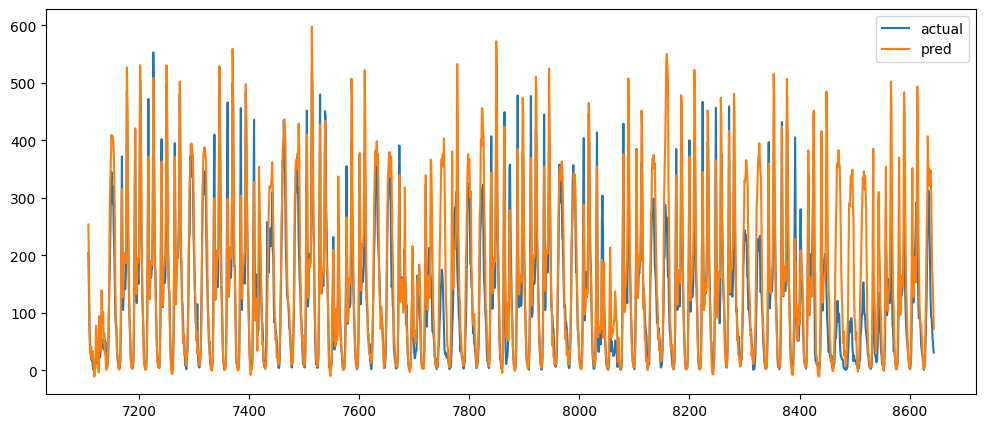

In [32]:
# 予測値が妥当か確認
train_value = train_y.values
_df = pd.DataFrame({'actual':test_y,'pred':pred_test_y})
_df.plot(figsize=(12,5))

おおむね、正しく予測出来てそう

### 特徴量の重要度確認

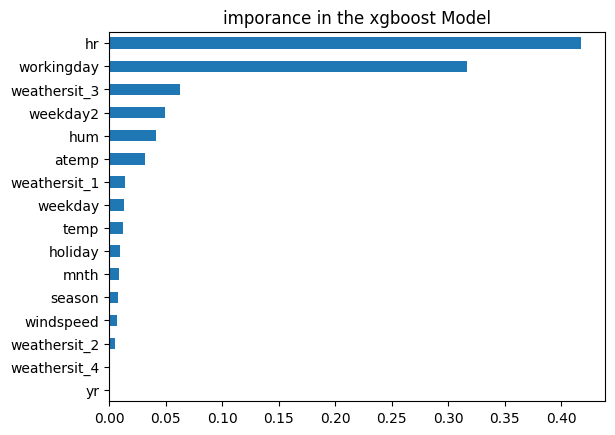

In [33]:
# feature importance のプロット
importances = pd.Series(reg.feature_importances_, index = train_X.columns)
importances = importances.sort_values()
importances.plot(kind = "barh")
plt.title("imporance in the xgboost Model")
plt.show()

時間が大きくかかわっていることがわかる。

In [34]:
from sklearn.metrics import mean_squared_error
# RMSE計算
rmse = np.sqrt(mean_squared_error(test_y, pred_test_y))
print('RMSE : {:.3f}'.format(rmse))


RMSE : 72.230


わりと良さそうだが、
前処理前のXGboostの方が良い、

### 提出ファイルの作成

In [35]:
# テストデータに対し予測値の算出
pred_test = reg.predict(X_test)

In [36]:
pred_test

array([ 76.47401 ,  54.40468 ,  36.867966, ..., 133.05652 ,  83.9906  ,
        62.701397], dtype=float32)

In [37]:
sub = test_df.copy()
sub['cnt'] = pred_test
sub.head(5)

,id,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,8646,2012-01-01,1,1,1,0,0,0,0,1,0.36,0.3788,0.66,0.0000,76.474007
1,8647,2012-01-01,1,1,1,1,0,0,0,1,0.36,0.3485,0.66,0.1343,54.404678
2,8648,2012-01-01,1,1,1,2,0,0,0,1,0.32,0.3485,0.76,0.0000,36.867966
3,8649,2012-01-01,1,1,1,3,0,0,0,1,0.30,0.3333,0.81,0.0000,27.706715
4,8650,2012-01-01,1,1,1,4,0,0,0,1,0.28,0.3030,0.81,0.0896,6.790998


In [38]:
# 提出ファイル
sub[['id','cnt']].to_csv('sample_submit_11.csv', index=False, header = False)

In [39]:
sample_submit_11 = pd.read_csv('sample_submit_11.csv')
sample_submit_11.head(5)

,8646,76.47401
0,8647,54.404680
1,8648,36.867966
2,8649,27.706715
3,8650,6.790998
4,8651,6.503993


### 評価  
RMSE  112.9892893(125/1246位)  
特徴量を整理することで、処理の前より、精度が3ほど上がった。  
別の学習モデルやアンサンブル学習などいろいろ出来そう。

02回帰  
03RNN  
01XGboost  
13スタッキング(ランダムフォレスト,lightgbm,xgboostの予測値を重回帰分析  
06simplelightGBM  
10LGBM OPtuna
11前処理プラスXGBoost
